In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from sklearn.svm import SVC

# Dane

In [2]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')

In [3]:
data.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


In [4]:
num_feature1 = 'subject_yrsed'  # RECODE of ppeduc (Education (Highest Degree Received))
num_feature2 = 'w6_q21b_year'  # year subject began romantic relationship with partner
cat_feature1 = 'w6_q34'  # how would you describe the quality of your relationship with partner?
cat_feature2 = 'w6_otherdate_dichotomous'  # did subject meet someone last year (other than current partner)?
label = 'S1'  # Are you married?

In [5]:
data[num_feature1].describe()

count    3510.000000
mean       13.945868
std         2.546054
min         0.000000
25%        12.000000
50%        13.000000
75%        16.000000
max        20.000000
Name: subject_yrsed, dtype: float64

In [6]:
data[num_feature2].describe()

count    3276.000000
mean     1995.875153
std        16.741519
min      1942.000000
25%      1983.000000
50%      2000.000000
75%      2010.000000
max      2017.000000
Name: w6_q21b_year, dtype: float64

In [7]:
data[cat_feature1].describe()

count          2856
unique            6
top       Excellent
freq           1706
Name: w6_q34, dtype: object

In [8]:
data[cat_feature2].describe()

count     3363
unique       2
top         no
freq      3034
Name: w6_otherdate_dichotomous, dtype: object

In [9]:
data[cat_feature1].unique()

[NaN, Excellent, Good, Fair, Very Poor, Poor, Refused]
Categories (6, object): [Refused < Excellent < Good < Fair < Poor < Very Poor]

In [10]:
data[cat_feature2].unique()

[yes, no, NaN]
Categories (2, object): [no < yes]

In [11]:
data[label].describe()

count                  3510
unique                    2
top       Yes, I am Married
freq                   2085
Name: S1, dtype: object

In [12]:
data[label].unique()

[No, I am not Married, Yes, I am Married]
Categories (2, object): [Yes, I am Married < No, I am not Married]

In [13]:
le1 = LabelEncoder()
le2 = LabelEncoder()
df = data[[num_feature1, num_feature2, cat_feature1, cat_feature2, label]]
df = df.dropna()
encoded_cat1 = le1.fit_transform(df[cat_feature1])
encoded_cat2 = le2.fit_transform(df[cat_feature2])
df[cat_feature1] = encoded_cat1
df[cat_feature2] = encoded_cat2
df[label] = df[label].apply(lambda x: 1 if x == 'Yes, I am Married' else 0)
df.head()

,subject_yrsed,w6_q21b_year,w6_q34,w6_otherdate_dichotomous,S1
1,17.0,1995.0,0,0,1
2,17.0,2006.0,2,0,1
4,16.0,1983.0,0,0,1
5,12.0,1982.0,2,0,1
6,12.0,1967.0,0,0,1


In [14]:
df.describe()

,subject_yrsed,w6_q21b_year,w6_q34,w6_otherdate_dichotomous
count,2745.000000,2745.000000,2745.000000,2745.000000
mean,14.074499,1995.526047,0.767942,0.079781
std,2.524083,16.638284,1.019343,0.271004
min,0.000000,1942.000000,0.000000,0.000000
25%,12.000000,1983.000000,0.000000,0.000000
50%,13.000000,1999.000000,0.000000,0.000000
75%,16.000000,2010.000000,2.000000,0.000000
max,20.000000,2017.000000,5.000000,1.000000


# Models

In [71]:
X = df.drop(label, axis=1)
y = df[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
xgb = XGBClassifier()
xgb.fit(X_train.values, y_train.values)
pred_y = xgb.predict(X_test.values)
score = accuracy_score(pred_y, y_test)
print(f'Accuracy xgb: {score}')
log_reg = LogisticRegression(solver = 'lbfgs', random_state=123)
log_reg.fit(X_train, y_train)
pred_y = log_reg.predict(X_test)
score = accuracy_score(pred_y, y_test)
print(f'Accuracy logistic: {score}')
svm = SVC(gamma='scale', probability=True, random_state=123)
svm.fit(X_train, y_train)
pred_y = svm.predict(X_test)
score = accuracy_score(pred_y, y_test)
print(f'Accuracy svm: {score}')

Accuracy xgb: 0.8355167394468704
Accuracy logistic: 0.7409024745269287
Accuracy svm: 0.7016011644832606


# Feature importance

In [46]:
def feature_importance(model, data, y):
    accuracy = defaultdict(list)
    original_accuracy = accuracy_score(y, model.predict(data))
    for i in range(1000):
        for col in data.columns:
            tmp_data = data.copy()
            tmp_data[col] = np.random.permutation(tmp_data[col].values)
            pred_y = model.predict(tmp_data)
            acc = accuracy_score(y, pred_y)
            accuracy[col].append(original_accuracy - acc)
    for k in accuracy:
        accuracy[k] = np.mean(accuracy[k])
    return accuracy

In [63]:
xgb_imp = feature_importance(xgb, X_test, y_test)
xgb_imp

defaultdict(list,
            {'subject_yrsed': 0.00033478893740901736,
             'w6_otherdate_dichotomous': 0.004439592430858796,
             'w6_q21b_year': 0.19876273653566234,
             'w6_q34': 0.005123726346433753})

In [60]:
log_imp = feature_importance(log_reg, X_test, y_test)
log_imp

defaultdict(list,
            {'subject_yrsed': 0.0016302765647744,
             'w6_otherdate_dichotomous': 0.07829694323144108,
             'w6_q21b_year': 0.0,
             'w6_q34': 0.0013245997088791972})

In [59]:
svm_imp = feature_importance(svm, X_test, y_test)
svm_imp

defaultdict(list,
            {'subject_yrsed': 0.0,
             'w6_otherdate_dichotomous': 0.0,
             'w6_q21b_year': 0.0,
             'w6_q34': 0.0})

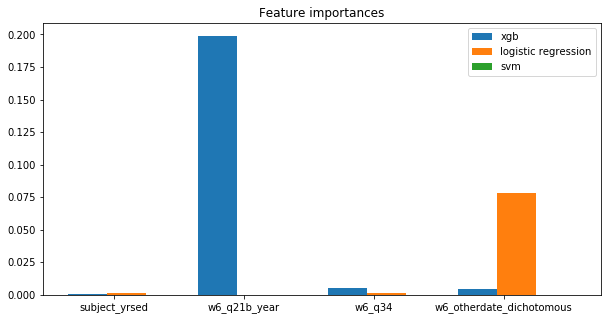

In [64]:
bar_width = 0.3
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(X.columns)), xgb_imp.values(), bar_width, label='xgb')
plt.bar(np.arange(len(X.columns)) + bar_width, log_imp.values(), bar_width, label='logistic regression')
plt.bar(np.arange(len(X.columns)) + 2 * bar_width, svm_imp.values(), bar_width, label='svm')

plt.xticks(np.array(range(len(log_imp)))+bar_width-1/10, log_imp.keys())
plt.title('Feature importances')
plt.legend()
plt.show()

In [85]:
def pdplot(model, features, feature, plt):
    feature_index = df.columns.get_loc(feature)
    #fig = plt.figure(figsize=(15, 10))
    unique_features = np.sort(np.unique(features[:,feature_index]))
    all_proba = []
    for j in range(features.shape[0]):
        x_to_predict = np.tile(features[j],(len(unique_features),1))
        x_to_predict[:,feature_index] = unique_features
        y = model.predict_proba(x_to_predict)[:,1]
        all_proba.append(y)
        plt.plot(unique_features, y, color = '0.75', zorder = 5, linewidth = 0.5)
    plt.plot(unique_features, np.mean(all_proba, axis = 0), color = 'black',linewidth = 5 , zorder = 15)
    #plt.xlabel(feature)
    #plt.ylabel('Married probability')
    #plt.title('Partial dependency profile')

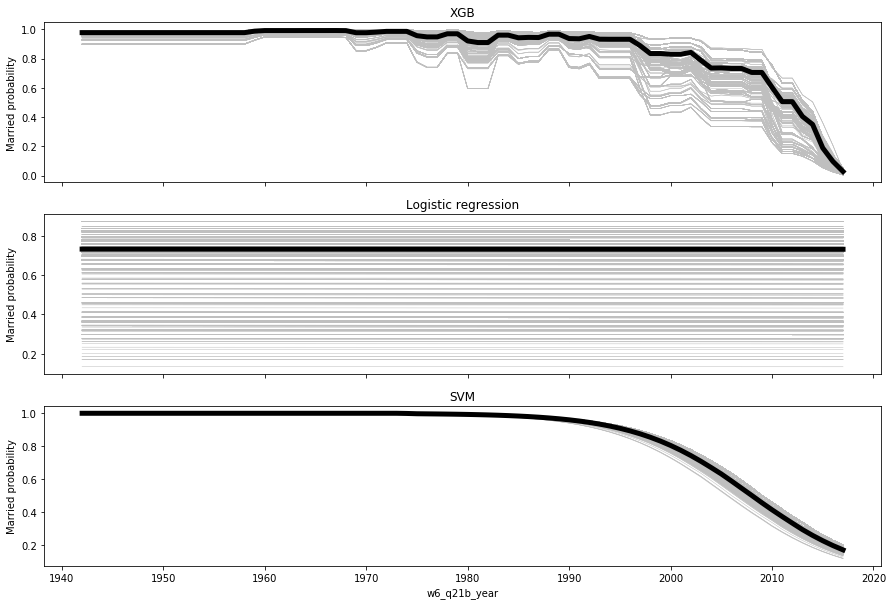

In [87]:
fig, ax = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(15,10))
pdplot(xgb, X.values, 'w6_q21b_year', ax[0])
ax[0].set_title('XGB')
pdplot(log_reg, X.values, 'w6_q21b_year', ax[1])
ax[1].set_title('Logistic regression')
pdplot(svm, X.values, 'w6_q21b_year', ax[2])
ax[2].set_title('SVM')
plt.xlabel('w6_q21b_year')
ax[0].set_ylabel('Married probability')
ax[1].set_ylabel('Married probability')
ax[2].set_ylabel('Married probability')

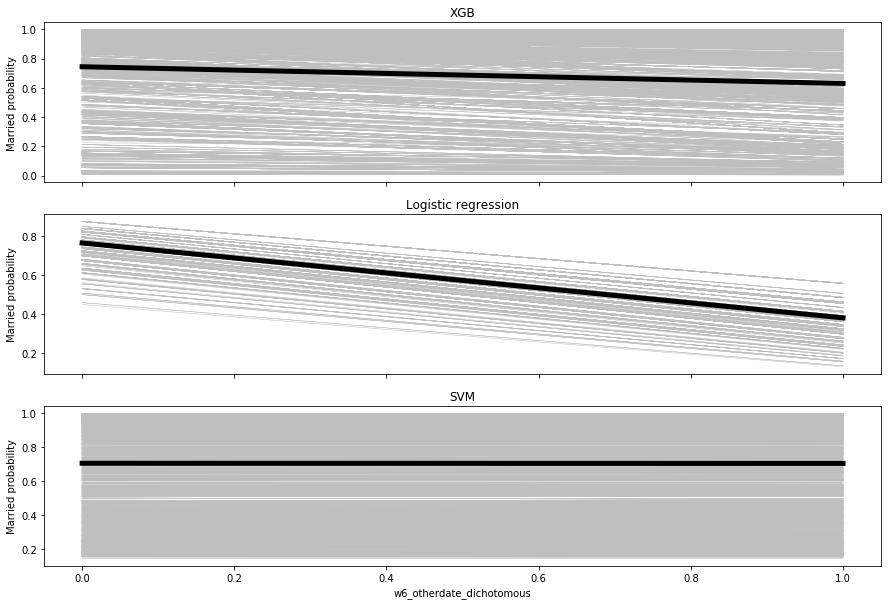

In [88]:
fig, ax = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(15,10))
pdplot(xgb, X.values, 'w6_otherdate_dichotomous', ax[0])
ax[0].set_title('XGB')
pdplot(log_reg, X.values, 'w6_otherdate_dichotomous', ax[1])
ax[1].set_title('Logistic regression')
pdplot(svm, X.values, 'w6_otherdate_dichotomous', ax[2])
ax[2].set_title('SVM')
plt.xlabel('w6_otherdate_dichotomous')
ax[0].set_ylabel('Married probability')
ax[1].set_ylabel('Married probability')
ax[2].set_ylabel('Married probability')

# Wnioski
Z ważności zmiennych widać, że mają one mały wpływ na wybrane modele XGBoost i LogisticRegression i SVM. Największe różnice występują przy zmiennej w6_q21b_year i w6_otherdate_dichotomous, gdzie pierwsza zmienna ma większy wpływ na model XGBoost a druga zmienna na regresję logistyczną.
Profile Partial dependency pokazują że regresja logistyczna zachowuje się liniowo co jest zgodne z naturą tego klasyfikatora. SVM pokazuje mniejszą zmienność dla zmiennej w6_otherdate_dichotomous i płynność zmiany dla w6_q21b_year. Największy wpływ na model XGBoost ma zmienna w6_q21b_year, charakter wpływu jest nie liniowy co jest zgodne z naturą modeli opartych na drzewach.